In [3]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN


In [4]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.garnet_trigger import GNNGraphClassifier
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm

In [5]:
DEVICE = "cuda:0"

In [6]:
model_result_folder = '../tracking_results/agnn/agnn-lr0.003039158491105233-b12-d64-PReLU-gi3-ln-True-n40000/experiment_2024-11-09_23:30:24'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
dphi_max, dz_max = data_config['phi_slope_max'], data_config['z0_max']

model_config = config.get('model', {})
model_config.pop('loss_func')
model_config.pop('name')
model = GNNGraphClassifier(**model_config).to(DEVICE)

def load_checkpoint(checkpoint_file, model, optimizer=None):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

# load_checkpoint
checkpoint_dir = os.path.join(model_result_folder, 'checkpoints')
checkpoint_file = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')])
checkpoint_file = checkpoint_file[-1]
print(checkpoint_file)
model = load_checkpoint(checkpoint_file, model)
print('Successfully reloaded!')

../tracking_results/agnn/agnn-lr0.003039158491105233-b12-d64-PReLU-gi3-ln-True-n40000/experiment_2024-11-09_23:30:24/checkpoints/model_checkpoint_006.pth.tar


/tmp/ipykernel_1734940/2215513823.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))


RuntimeError: Error(s) in loading state_dict for GNNGraphClassifier:
	Missing key(s) in state_dict: "node_network.network.module_0.transform_in.weight", "node_network.network.module_0.transform_in.bias", "node_network.network.module_0.aggregator_score.weight", "node_network.network.module_0.aggregator_score.bias", "node_network.network.module_0.transform_out.0.weight", "node_network.network.module_0.transform_out.0.bias", "node_network.network.module_0.transform_out.1.weight", "node_network.network.module_1.weight", "node_network.network.module_1.bias", "node_network.network.module_2.transform_in.weight", "node_network.network.module_2.transform_in.bias", "node_network.network.module_2.aggregator_score.weight", "node_network.network.module_2.aggregator_score.bias", "node_network.network.module_2.transform_out.0.weight", "node_network.network.module_2.transform_out.0.bias", "node_network.network.module_2.transform_out.1.weight", "node_network.network.module_3.weight", "node_network.network.module_3.bias", "node_network.network.module_4.transform_in.weight", "node_network.network.module_4.transform_in.bias", "node_network.network.module_4.aggregator_score.weight", "node_network.network.module_4.aggregator_score.bias", "node_network.network.module_4.transform_out.0.weight", "node_network.network.module_4.transform_out.0.bias", "node_network.network.module_4.transform_out.1.weight", "node_network.network.module_5.weight", "node_network.network.module_5.bias", "graph_pred_mlp.0.weight", "graph_pred_mlp.0.bias", "graph_pred_mlp.1.weight", "graph_pred_mlp.1.bias", "graph_pred_mlp.2.weight", "graph_pred_mlp.3.weight", "graph_pred_mlp.3.bias", "graph_pred_mlp.4.weight", "graph_pred_mlp.4.bias", "graph_pred_mlp.5.weight", "graph_pred_mlp.6.weight", "graph_pred_mlp.6.bias", "graph_pred_mlp.7.weight", "graph_pred_mlp.7.bias", "graph_pred_mlp.8.weight", "graph_pred_mlp.9.weight", "graph_pred_mlp.9.bias". 
	Unexpected key(s) in state_dict: "edge_network.network.0.weight", "edge_network.network.0.bias", "edge_network.network.1.weight", "edge_network.network.1.bias", "edge_network.network.2.weight", "edge_network.network.3.weight", "edge_network.network.3.bias", "edge_network.network.4.weight", "edge_network.network.4.bias", "edge_network.network.5.weight", "edge_network.network.6.weight", "edge_network.network.6.bias", "edge_network.network.7.weight", "edge_network.network.7.bias", "edge_network.network.8.weight", "edge_network.network.9.weight", "edge_network.network.9.bias", "node_network.network.0.weight", "node_network.network.0.bias", "node_network.network.1.weight", "node_network.network.1.bias", "node_network.network.2.weight", "node_network.network.3.weight", "node_network.network.3.bias", "node_network.network.4.weight", "node_network.network.4.bias", "node_network.network.5.weight", "node_network.network.6.weight", "node_network.network.6.bias", "node_network.network.7.weight", "node_network.network.7.bias", "node_network.network.8.weight", "node_network.network.9.weight", "node_network.network.9.bias", "node_network.network.10.weight", "node_network.network.10.bias", "node_network.network.11.weight". 

In [4]:
data_config['input_dir'] = '/ssd3/giorgian/hits-data-september-run2024pp/0/'
data_config['n_folders'] = 1
data_config['n_mix'] = 1
data_config['n_train'] = 13955
data_config['n_valid'] = 0
data_config['batch_size'] = 1

In [5]:
data_config

{'batch_size': 1,
 'construct_edges': False,
 'input_dir': '/ssd3/giorgian/hits-data-september-run2024pp/0/',
 'input_dir2': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'load_full_event': False,
 'n_folders': 1,
 'n_mix': 1,
 'n_train': 13955,
 'n_valid': 0,
 'n_workers': 16,
 'name': 'hit_graph_trigger_pileup',
 'phi_slope_max': 0.012193355583173944,
 'real_weight': 1,
 'z0_max': 14.220353082111805}

In [6]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)


In [11]:
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
data_config['n_train'] = 13955
data_config['n_valid'] = 0
data_config['batch_size'] = 1
train_data_loader_s, valid_data_loader_s = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)

In [16]:
preds_s, targets_s = [], []
n_hits_s = []
sigmoid = torch.nn.Sigmoid()
model.eval()
for batch in tqdm(train_data_loader_s):
    preds_s.append(model(batch.to(DEVICE)).squeeze(0).detach().cpu().numpy())
    targets_s.append(batch.trigger.squeeze(0).detach().cpu().numpy())
    n_hits_s.append(batch.x.shape[0])

  0%|          | 0/27910 [00:00<?, ?it/s]

In [7]:
len(train_data_loader)

13955

In [8]:
preds, targets = [], []
n_hits = []
sigmoid = torch.nn.Sigmoid()
model.eval()
for batch in tqdm(train_data_loader):
    preds.append(model(batch.to(DEVICE)).squeeze(0).detach().cpu().numpy())
    targets.append(batch.trigger.squeeze(0).detach().cpu().numpy())
    n_hits.append(batch.x.shape[0])

  0%|          | 0/13955 [00:00<?, ?it/s]

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN/models/garnet_trigger.py:127: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/torch/csrc/tensor/python_tensor.cpp:78.)
  temp = torch.cuda.FloatTensor(x.shape[0]).fill_(1)


In [9]:
n_hits_real = list(n_hits)

(array([  166.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13789.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

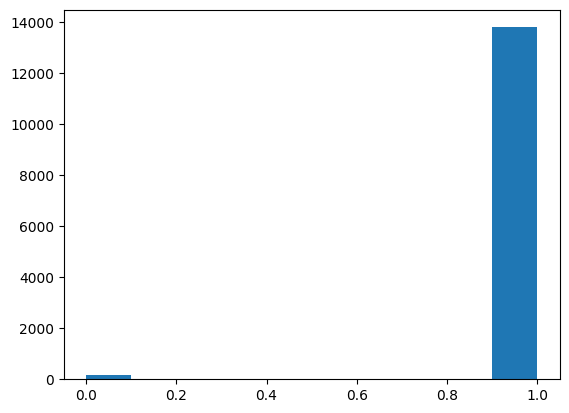

In [20]:
plt.hist((np.array(preds) > 0).astype(int))

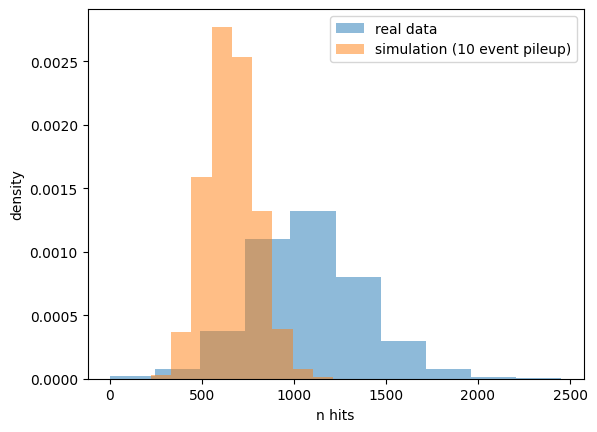

In [28]:
plt.hist(n_hits_real, density=True, alpha=0.5, label='real data')
plt.hist(n_hits_s, density=True, alpha=0.5, label='simulation (10 event pileup)')
plt.xlabel('n hits')
plt.ylabel('density')
plt.legend()

(array([8.400e+01, 1.132e+03, 4.883e+03, 8.516e+03, 7.774e+03, 4.048e+03,
        1.205e+03, 2.280e+02, 3.600e+01, 4.000e+00]),
 array([ 224.,  334.,  444.,  554.,  664.,  774.,  884.,  994., 1104.,
        1214., 1324.]),
 <BarContainer object of 10 artists>)

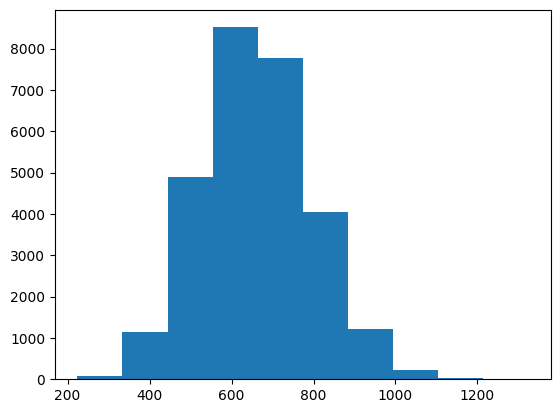

In [18]:
plt.hist(n_hits_s)
plt

# 